In [1]:
import os
import logging
import numpy as np
import librosa
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import random
import mlflow
import mlflow.pytorch
from tqdm import tqdm

# --- MUTE TENSORFLOW WARNINGS (Hanya dipakai buat extract fitur) ---
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import tensorflow as tf
import tensorflow_hub as hub

# --- PYTORCH IMPORTS ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, f1_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight

c:\Users\andiz\anaconda3\envs\roodio-env\Lib\site-packages\tensorflow_hub\__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


In [8]:
# --- KONFIGURASI ---
SOURCE_DIRS = ['../../../data/raw', '../../../data/raw2']  # Sesuaikan path folder Anda
FOLDS = 5
SEED = 43
TARGET_SR = 16000
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.001
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- LOCK ACCURACY (Reproducibility) ---
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# MLflow Setup
MLFLOW_TRACKING_URI = r"file:///C:/CAWU4GROUP3/projects/projectRoodio/machineLearning/mlruns"
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment("Hierarchical_Stage1_PyTorch")

<Experiment: artifact_location='file:///C:/CAWU4GROUP3/projects/projectRoodio/machineLearning/mlruns/483717708782191684', creation_time=1771654254792, experiment_id='483717708782191684', last_update_time=1771654254792, lifecycle_stage='active', name='Hierarchical_Stage1_PyTorch', tags={'mlflow.experimentKind': 'custom_model_development'}>

In [9]:
# ==============================================================================
# 1. HELPER & FEATURE EXTRACTION (YAMNet via TF Hub)
# ==============================================================================
print("⏳ Loading YAMNet (Feature Extractor)...")
# Kita tetap pakai TF Hub cuma buat ambil angka-angkanya (Embedding)
# Nanti training-nya murni PyTorch.
yamnet_model = hub.load("https://tfhub.dev/google/yamnet/1")

def trim_middle(y, sr, percentage=0.5):
    if len(y) < sr: return y
    start = int(len(y) * (1 - percentage) / 2)
    end = start + int(len(y) * percentage)
    return y[start:end]

def extract_features(y):
    try:
        y = y.astype(np.float32)
        # Normalisasi
        if np.max(np.abs(y)) > 0: 
            y_norm = y / np.max(np.abs(y))
        else: 
            y_norm = y
        
        # Padding
        if len(y_norm) < TARGET_SR: 
            y_norm = np.pad(y_norm, (0, TARGET_SR - len(y_norm)))
            
        # Extract Embedding via YAMNet
        _, embeddings, _ = yamnet_model(y_norm)
        
        # Statistik Embedding (Convert Tensor to Numpy)
        emb_mean = tf.reduce_mean(embeddings, axis=0).numpy()
        emb_std  = tf.math.reduce_std(embeddings, axis=0).numpy()
        emb_max  = tf.reduce_max(embeddings, axis=0).numpy()
        
        # Audio Features Tambahan
        rms = np.mean(librosa.feature.rms(y=y))
        zcr = np.mean(librosa.feature.zero_crossing_rate(y=y))
        
        # Gabung jadi satu vector (1024 + 1024 + 1024 + 2 = 3074 fitur)
        return np.concatenate([emb_mean, emb_std, emb_max, [rms, zcr]]).astype(np.float32)
    except Exception as e:
        return None

def augment_audio(y):
    # Augmentasi Noise & Shift
    # Gunakan generator lokal atau state yang konsisten jika ingin benar-benar terkunci
    # Namun basic np.random.seed sudah cukup di sini.
    noise_amp = 0.005 * np.random.uniform() * np.amax(y)
    y_noise = y.astype('float64') + noise_amp * np.random.normal(size=y.shape[0])
    
    shift_len = int(TARGET_SR * 0.5)
    direction = np.random.choice([True, False])
    y_shift = np.roll(y, shift_len) if direction else np.roll(y, -shift_len)
        
    return [y_noise.astype(np.float32), y_shift.astype(np.float32)]

⏳ Loading YAMNet (Feature Extractor)...


In [10]:
# ==============================================================================
# 2. LOAD DATASET (AUDIO FILES)
# ==============================================================================
print("📥 Loading Audio Files...")
audio_raw_data = [] 
raw_labels = []

moods = ['angry', 'happy', 'sad', 'relaxed']

for source_dir in SOURCE_DIRS:
    if not os.path.exists(source_dir):
        continue
    
    print(f"   📂 Scanning: {source_dir}...")
    for mood in moods:
        folder = os.path.join(source_dir, mood)
        if not os.path.exists(folder): continue
        
        files = os.listdir(folder)
        for f in tqdm(files, desc=f"Load {mood}", leave=False):
            if not f.endswith(('.wav', '.mp3')): continue
            path = os.path.join(folder, f)
            try:
                y, sr = librosa.load(path, sr=TARGET_SR)
                y = trim_middle(y, sr)
                audio_raw_data.append(y)
                # Labeling: Angry/Happy -> High (0), Sad/Relaxed -> Low (1)
                # Nanti di-encode otomatis
                raw_labels.append('high' if mood in ['angry', 'happy'] else 'low')
            except: continue

print(f"✅ Total Audio Loaded: {len(audio_raw_data)}")

📥 Loading Audio Files...
   📂 Scanning: ../../../data/raw...


   📂 Scanning: ../../../data/raw2...


✅ Total Audio Loaded: 200


In [11]:
# ==============================================================================
# 3. PYTORCH MODEL ARCHITECTURE
# ==============================================================================
class AudioClassifier(nn.Module):
    def __init__(self, input_dim):
        super(AudioClassifier, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2)
        )
        self.output = nn.Linear(256, 2) # Output 2 kelas (logits)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        return self.output(x)

# Custom Dataset Class
class AudioDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
    def __len__(self): return len(self.labels)
    def __getitem__(self, idx): return self.features[idx], self.labels[idx]


In [12]:
# ==============================================================================
# 4. TRAINING LOOP (5-FOLD)
# ==============================================================================
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
le = LabelEncoder()
y_encoded = le.fit_transform(raw_labels) # 0=High, 1=Low (atau sebaliknya)

# Simpan Encoder (PENTING BUAT INFERENCE)
os.makedirs('../../../models/v3', exist_ok=True)
joblib.dump(le, '../../../models/v3/stage1_encoder.pkl')

acc_scores = []
y_true_total = []
y_pred_total = []
best_model_state = None
best_overall_acc = 0.0

print(f"\n🚀 START TRAINING LOOP ({FOLDS}-Fold)...")

with mlflow.start_run(run_name=f"CV_{FOLDS}Fold_PyTorch_Locked"):
    mlflow.log_params({
        "folds": FOLDS,
        "seed": SEED,
        "batch_size": BATCH_SIZE,
        "epochs": EPOCHS,
        "learning_rate": LEARNING_RATE
    })

    for fold, (train_idx, val_idx) in enumerate(skf.split(audio_raw_data, y_encoded)):
        print(f"\n🔄 FOLD {fold+1}/{FOLDS}")
        
        # --- A. Feature Extraction & Augmentation (On the Fly per Fold) ---
        X_train, y_train = [], []
        X_val, y_val = [], []
        
        # Process Train Data (With Augmentation)
        for i in train_idx:
            y_raw = audio_raw_data[i]
            label = y_encoded[i]
            
            # Original
            feat = extract_features(y_raw)
            if feat is not None:
                X_train.append(feat)
                y_train.append(label)
                
            # Augmentasi (Hanya data training)
            for y_aug in augment_audio(y_raw) :
                feat_aug = extract_features(y_aug)
                if feat_aug is not None:
                    X_train.append(feat_aug)
                    y_train.append(label)

        # Process Val Data (No Augmentation)
        for i in val_idx:
            feat = extract_features(audio_raw_data[i])
            if feat is not None:
                X_val.append(feat)
                y_val.append(y_encoded[i])
                
        # Convert to Tensors
        train_dataset = AudioDataset(X_train, y_train)
        val_dataset = AudioDataset(X_val, y_val)
        
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
        
        # --- B. Class Weights ---
        class_counts = np.bincount(y_train)
        weights = 1. / class_counts
        # samples_weights = weights * len(y_train) / 2 # Balance factor (Sesuai code user)
        class_weights_tensor = torch.tensor(weights, dtype=torch.float32).to(DEVICE)
        
        # --- C. Init Model ---
        input_dim = X_train[0].shape[0] # Harusnya 3074
        model = AudioClassifier(input_dim).to(DEVICE)
        
        criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
        
        # Early Stopping Vars
        patience = 15
        best_val_loss = float('inf')
        counter = 0
        best_fold_model = None
        fold_best_preds = []
        fold_best_labels = []
        
        # --- D. Epoch Loop ---
        for epoch in range(EPOCHS):
            model.train()
            train_loss = 0
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
                
                optimizer.zero_grad()
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                
            # Validation
            model.eval()
            val_loss = 0
            all_preds = []
            all_labels = []
            with torch.no_grad():
                for X_batch, y_batch in val_loader:
                    X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
                    outputs = model(X_batch)
                    loss = criterion(outputs, y_batch)
                    val_loss += loss.item()
                    
                    _, preds = torch.max(outputs, 1)
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(y_batch.cpu().numpy())
            
            val_loss /= len(val_loader)
            val_acc = accuracy_score(all_labels, all_preds)
            
            # Early Stopping Check
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_fold_model = model.state_dict()
                fold_best_preds = all_preds
                fold_best_labels = all_labels
                counter = 0
            else:
                counter += 1
                if counter >= patience:
                    break # Stop training this fold
        
        acc_scores.append(val_acc)
        y_true_total.extend(fold_best_labels)
        y_pred_total.extend(fold_best_preds)
        print(f"   🎯 Fold Acc: {val_acc*100:.2f}%")
        mlflow.log_metric(f"fold_{fold+1}_acc", val_acc)
        
        # Save best model overall
        if val_acc > best_overall_acc:
            best_overall_acc = val_acc
            best_model_state = best_fold_model


🚀 START TRAINING LOOP (5-Fold)...

🔄 FOLD 1/5


C:\Users\andiz\AppData\Local\Temp\ipykernel_40620\4070398879.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:256.)
  self.features = torch.tensor(features, dtype=torch.float32)


   🎯 Fold Acc: 90.00%

🔄 FOLD 2/5
   🎯 Fold Acc: 87.50%

🔄 FOLD 3/5
   🎯 Fold Acc: 80.00%

🔄 FOLD 4/5
   🎯 Fold Acc: 80.00%

🔄 FOLD 5/5
   🎯 Fold Acc: 82.50%



📊 Rata-rata Akurasi: 84.00%
🏆 Best Accuracy: 90.00%

📝 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

        high       0.88      0.76      0.82       100
         low       0.79      0.90      0.84       100

    accuracy                           0.83       200
   macro avg       0.84      0.83      0.83       200
weighted avg       0.84      0.83      0.83       200



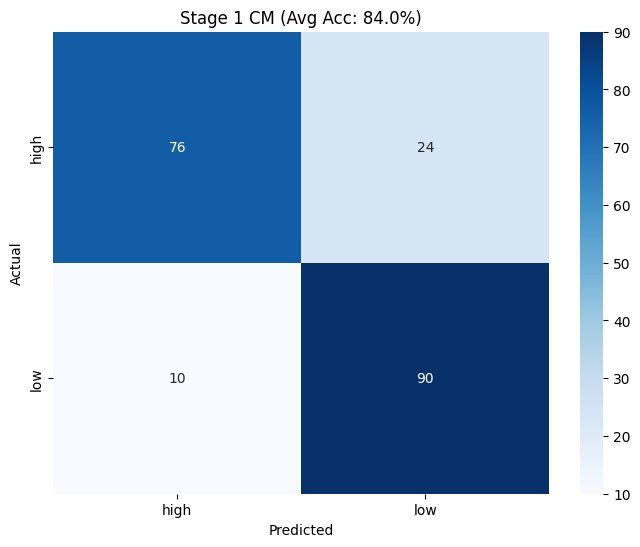

💾 Model Stage 1 (PyTorch) Saved: ../../../models/v3/stage1_nn.pth
   (Format .pth ini AMAN dari error Hugging Face)


In [ ]:
# ==============================================================================
# 5. FINAL EVALUATION & SAVE
# ==============================================================================
print("\n" + "="*50)
print(f"📊 Rata-rata Akurasi: {np.mean(acc_scores)*100:.2f}%")
print(f"🏆 Best Accuracy: {best_overall_acc*100:.2f}%")

print("\n📝 CLASSIFICATION REPORT:")
print(classification_report(y_true_total, y_pred_total, target_names=le.classes_))

cm = confusion_matrix(y_true_total, y_pred_total)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f'Stage 1 CM (Avg Acc: {np.mean(acc_scores)*100:.1f}%)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
cm_path = 'results/cm_stage1_pytorch.png'
plt.savefig(cm_path)
plt.show()

if best_model_state is not None:
    save_path = '../../../models/v3/stage1_nn.pth'
    torch.save(best_model_state, save_path)
    mlflow.log_metric("mean_accuracy", np.mean(acc_scores))
    mlflow.log_metric("std_accuracy", np.std(acc_scores))
    
    # Log weighted F1 score for the entire CV set
    cv_f1 = f1_score(y_true_total, y_pred_total, average='weighted')
    mlflow.log_metric("cv_f1_score", cv_f1)
    
    mlflow.log_artifact(cm_path)
    mlflow.log_artifact(save_path)
    print(f"💾 Model Stage 1 (PyTorch) Saved: {save_path}")
    print("   (Format .pth ini AMAN dari error Hugging Face)")
else:
    print("❌ Training gagal menghasilkan model.")